# Conservation Analysis of Genomic Features

This notebook analyzes conservation patterns in alternative transcript regions using PhyloCSF and PhyloP scores. The analysis pipeline is designed to handle multiple types of genomic features:
- N-terminal extensions (ctes)
- C-terminal extensions (CTEs)
- Intronic regions

## Setup
First, we'll import required libraries and set up our basic configuration. We use:
- `polars` for efficient data manipulation
- `pyranges` for genomic icterval operations
- `pyBigWig` for accessing conservation scores
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for visualization

In [1]:
# Standard libraries
from pathlib import Path
import sys
from typing import List, Optional, Dict, Tuple
from datetime import datetime

# Add project root to Python path for imports
project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

# Custom utilities
from src.utils import ConservationTracker, ConservationAnalyzer, BEDHandler

# Data handling
import polars as pl
import numpy as np
import pyranges as pr
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme()
sns.set_context("notebook")

## Configuration

Set up paths and parameters for the analysis. This notebook is configured for N-terminal extensions (ctes), but the same structure can be used for CTEs and intronic regions by modifying these parameters.

Key parameters:
- Feature type (NTE/CTE/intronic)
- Input paths for feature data, annotations, and conservation scores
- Analysis parameters like window size
- Output directory structure

In [18]:
# Define feature type
FEATURE_TYPE = "Untranslated_INTRONIC_EXTENDED"  # One of: "NTE", "CTE", "INTRONIC"

# Set up directory structure
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "results" / FEATURE_TYPE.lower()
BEDs = RESULTS_DIR / "bed"
FIGs = RESULTS_DIR / "figures"
TABLES = RESULTS_DIR / "tables"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
BEDs.mkdir(parents=True, exist_ok=True)
FIGs.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

# Input paths
feature_path = DATA_DIR / "raw" / "intron_not_predicted.bed12"
gencode_path = DATA_DIR / "raw" / "gencode.v47.annotation.gtf"
phylocsf_dir = DATA_DIR / "raw" / "phylocsf"
phylop_path = DATA_DIR / "raw" / "phyloP" / "PhyloP_470way.bw"

# Analysis parameters
WINDOW_SIZE = 30  # Size of sliding window for conservation analysis
MIN_REGION_SIZE = 10  # Minimum size of region to analyze
SCORE_THRESHOLD = 0  # Threshold for calling positive conservation

# Initialize our utility classes
conservation_tracker = ConservationTracker(phylocsf_dir, phylop_path)
conservation_analyzer = ConservationAnalyzer(window_size=WINDOW_SIZE)
bed_handler = BEDHandler()

# Verify paths exist
for path in [feature_path, gencode_path, phylocsf_dir, phylop_path]:
    if not path.exists():
        raise FileNotFoundError(f"Required file/directory not found: {path}")

print("Configuration complete. Analysis will use:")
print(f"- Feature type: {FEATURE_TYPE}")
print(f"- Feature data: {feature_path}")
print(f"- Results directory: {RESULTS_DIR}")

Configuration complete. Analysis will use:
- Feature type: Untranslated_INTRONIC_EXTENDED
- Feature data: ../data/raw/intron_not_predicted.bed12
- Results directory: ../results/untranslated_intronic_extended


## Data Loading and Preprocessing

Load our N-terminal extension data from the BED12 file and prepare it for analysis. Steps include:
1. Load the BED12 file using our custom handler
2. Extract transcript IDs from feature names
3. Basic QC checks on the loaded data
4. Display summary statistics of our features

Loading feature data...

Feature Statistics:
Total features loaded: 38789

Chromosome distribution:
shape: (30, 2)
┌────────────┬───────┐
│ chrom      ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ 1          ┆ 4033  │
│ 10         ┆ 1674  │
│ 11         ┆ 2226  │
│ 12         ┆ 2177  │
│ 13         ┆ 709   │
│ …          ┆ …     │
│ KI270727.1 ┆ 6     │
│ KI270728.1 ┆ 2     │
│ KI270734.1 ┆ 3     │
│ X          ┆ 1334  │
│ Y          ┆ 75    │
└────────────┴───────┘

Strand distribution:
shape: (2, 2)
┌────────┬───────┐
│ strand ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ +      ┆ 19793 │
│ -      ┆ 18996 │
└────────┴───────┘

Length statistics:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ region_length │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 38789.0       │
│ null_count ┆ 0.0           │
│ mean       ┆ 73.00629      │
│ std        ┆ 63.539771

/tmp/ipykernel_111212/2832992967.py:18: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
/tmp/ipykernel_111212/2832992967.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("strand").agg(pl.count()))


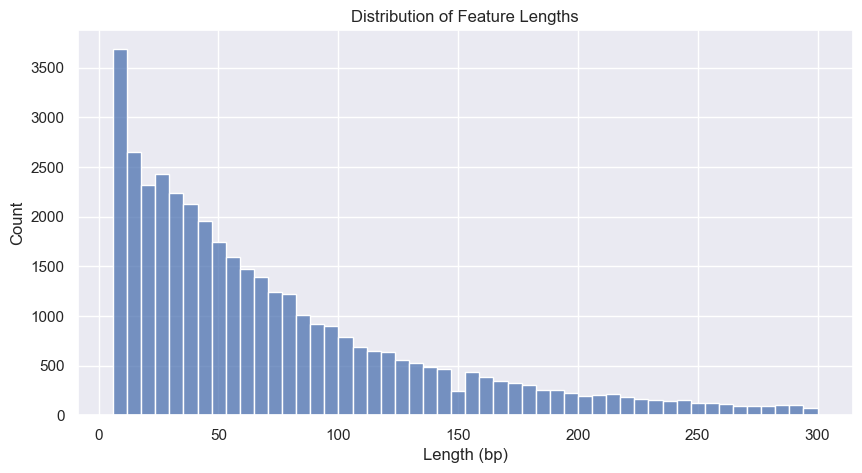


Data loading and preprocessing complete.


In [3]:
# Load feature data using our BED handler
print("Loading feature data...")
feature_df = bed_handler.load_bed12(feature_path)

# Extract transcript IDs from names and add region length
feature_df = feature_df.with_columns([
    # Extract transcript ID from feature name (assumes format: ENST00000123456_...)
    pl.col("name").str.split("_").list.first().alias("transcript_id"),
    
    # Calculate region length
    (pl.col("chromEnd") - pl.col("chromStart")).alias("region_length")
])

# Print basic statistics
print("\nFeature Statistics:")
print(f"Total features loaded: {len(feature_df)}")
print("\nChromosome distribution:")
print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
print("\nStrand distribution:")
print(feature_df.group_by("strand").agg(pl.count()))
print("\nLength statistics:")
print(feature_df.select("region_length").describe())

# Quick length distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(data=feature_df.to_pandas(), x="region_length", bins=50)
plt.title("Distribution of Feature Lengths")
plt.xlabel("Length (bp)")
plt.ylabel("Count")
plt.show()

print("\nData loading and preprocessing complete.")

## Extension Region Identification

Before calculating conservation scores, we need to precisely identify the extension regions by:
1. Loading CDS annotations from GENCODE
2. Identifying the correct CDS start/end positions
3. Determining the extension coordinates based on strand orientation:
   - For + strand: region between chromStart and CDS start
   - For - strand: region between CDS end and chromEnd
4. Validating extension regions

In [4]:
# Load GENCODE annotation
print("Loading GENCODE v47 annotation...")
gr = pr.read_gtf(gencode_path)

# Get both CDS and exon annotations
cds_annotation = gr[gr.Feature == "CDS"]
exon_annotation = gr[gr.Feature == "exon"]

print(f"Found {len(cds_annotation)} CDS entries in GENCODE v47")
print(f"Found {len(exon_annotation)} exon entries in GENCODE v47")


Loading GENCODE v47 annotation...
Found 901768 CDS entries in GENCODE v47
Found 2155005 exon entries in GENCODE v47


In [7]:
def identify_cds_introns(cds_blocks_df):
    """
    Identify introns between CDS blocks while properly handling strand orientation.

    Args:
        cds_blocks_df: DataFrame containing CDS blocks from PyRanges GTF
                      Contains columns: Start, End, Strand, transcript_id

    Returns:
        DataFrame containing intron coordinates
    """
    introns = []

    # Group CDS blocks by transcript_id
    for transcript_id, group in cds_blocks_df.groupby('transcript_id'):
        # Sort CDS blocks based on genomic coordinates
        # For - strand, we'll reverse the order later if needed
        blocks = group.sort_values('Start').to_dict('records')

        if len(blocks) <= 1:
            continue

        # Get strand information
        strand = blocks[0]['Strand']

        # For minus strand, reverse the order of blocks
        if strand == '-':
            blocks = blocks[::-1]

        # Iterate through adjacent CDS blocks
        for i in range(len(blocks) - 1):
            current_cds = blocks[i]
            next_cds = blocks[i + 1]

            # Define intron boundaries based on strand
            if strand == '+':
                intron_start = current_cds['End']
                intron_end = next_cds['Start']
            else:
                intron_start = next_cds['End']
                intron_end = current_cds['Start']

            # Validate intron coordinates
            if intron_start >= intron_end:
                continue

            introns.append({
                'transcript_id': transcript_id,
                'strand': strand,
                'intron_start': intron_start,
                'intron_end': intron_end,
                'chromosome': current_cds['Chromosome'],  # PyRanges uses 'Chromosome'
            })

    return pd.DataFrame(introns)

# Get CDS annotations and ensure transcript_id is available
cds_annotation = gr[gr.Feature == "CDS"]
cds_df = cds_annotation.as_df()

# Extract transcript_id from attributes if needed
if 'transcript_id' not in cds_df.columns:
    print("Extracting transcript_id from attributes...")
    # GTF format stores transcript_id in attributes column
    cds_df['transcript_id'] = cds_df['gene_name'].str.extract('transcript_id "([^"]+)"')

print(f"Found {len(cds_annotation)} CDS entries in GENCODE v47")
print("Identifying introns between CDS blocks...")
cds_introns = identify_cds_introns(cds_df)

Found 901768 CDS entries in GENCODE v47
Identifying introns between CDS blocks...


In [8]:
def calculate_all_scores(feature_df, cds_introns_pl, conservation_tracker, conservation_analyzer):
    """
    Calculate conservation metrics for both translated regions and full CDS introns
    """
    from time import time
    import numpy as np
    
    # Initialize lists for all our metrics
    metrics_lists = {
        # Translated region metrics
        'translated_frame_score': [],    # Score in translated region
        'translated_max_score': [],      # Best frame in translated region
        'translated_phylop': [],         # PhyloP in translated region
        'translated_window_max': [],     # Best 30bp window in translated region
        
        # Untranslated intron metrics
        'untranslated_frame_score': [],  # Score in untranslated regions
        'untranslated_max_score': [],    # Best frame in untranslated regions
        'untranslated_phylop': [],       # PhyloP in untranslated regions
        'untranslated_window_max': [],   # Best 30bp window in untranslated regions
        
        # Region lengths
        'translated_length': [],         # Length of translated region
        'untranslated_length': [],      # Length of untranslated regions
        'intron_start': [],             # Full intron start
        'intron_end': [],               # Full intron end
        'frame': []                      # Frame of translation
    }
    
    total_features = len(feature_df)
    processed = 0
    matches_found = 0
    
    for row in feature_df.iter_rows(named=True):
        if processed % 100 == 0:
            print(f"Processed {processed}/{total_features} features "
                  f"({processed/total_features*100:.1f}%)")
        
        processed += 1
        
        # Initialize default values
        current_metrics = {key: None for key in metrics_lists.keys()}
        
        # Find matching introns
        matching_introns = cds_introns_pl.filter(
            (pl.col("chromosome") == f"chr{row['chrom']}") &
            (pl.col("intron_start") <= row['thickStart']) &
            (pl.col("intron_end") >= row['thickEnd']) &
            (pl.col("strand") == row['strand'])
        )
        
        if processed <= 2:  # Debug first 5 entries
            print(f"\nProcessing entry {processed}:")
            print(f"Looking for introns in transcript matching:")
            print(f"Chrom: chr{row['chrom']}")
            print(f"Region: {row['thickStart']}-{row['thickEnd']}")
            print(f"Strand: {row['strand']}")
            print(f"Found {len(matching_introns)} matching introns:")
            print(matching_introns)
        
        if len(matching_introns) == 0:
            # Add None values for this row
            for key in metrics_lists:
                metrics_lists[key].append(None)
            continue
        
        matches_found += 1
        # Convert first matching intron to dict for easier access
        intron_dict = matching_introns.row(0, named=True)
        
        current_metrics['intron_start'] = intron_dict['intron_start']
        current_metrics['intron_end'] = intron_dict['intron_end']
        
        # Calculate frame
        frame = (row['thickStart'] - intron_dict['intron_start']) % 3 + 1
        current_metrics['frame'] = frame
        
        # 1. Analyze translated region
        translated_scores, translated_phylop = conservation_tracker.get_conservation_scores(
            row['chrom'],
            row['thickStart'],
            row['thickEnd'],
            row['strand']
        )
        
        current_metrics['translated_length'] = row['thickEnd'] - row['thickStart']
        
        if translated_scores:
            frame_means = {
                f: np.nanmean(scores) if len(scores) > 0 else np.nan 
                for f, scores in translated_scores.items()
            }
            
            current_metrics['translated_frame_score'] = frame_means.get(frame)
            current_metrics['translated_max_score'] = max(frame_means.values())
            
            scores = translated_scores[frame]
            if len(scores) >= 30:
                windows = [
                    np.nanmean(scores[i:i+30])
                    for i in range(len(scores) - 30 + 1)
                ]
                current_metrics['translated_window_max'] = float(max(windows))
        
        if translated_phylop is not None:
            current_metrics['translated_phylop'] = float(np.nanmean(translated_phylop))
        
        # 2. Analyze untranslated regions
        untranslated_regions = []
        if row['thickStart'] > intron_dict['intron_start']:
            untranslated_regions.append((
                intron_dict['intron_start'],
                row['thickStart']
            ))
        if row['thickEnd'] < intron_dict['intron_end']:
            untranslated_regions.append((
                row['thickEnd'],
                intron_dict['intron_end']
            ))
        
        # Combine scores from all untranslated regions
        all_untranslated_scores = {1: [], 2: [], 3: []}
        all_untranslated_phylop = []
        total_untranslated_length = 0
        
        for start, end in untranslated_regions:
            scores, phylop = conservation_tracker.get_conservation_scores(
                row['chrom'],
                start,
                end,
                row['strand']
            )
            
            total_untranslated_length += end - start
            
            if scores:
                for frame_num in [1, 2, 3]:
                    all_untranslated_scores[frame_num].extend(scores.get(frame_num, []))
            
            if phylop is not None:
                all_untranslated_phylop.extend(phylop)
        
        current_metrics['untranslated_length'] = total_untranslated_length
        
        if any(all_untranslated_scores.values()):
            frame_means = {
                f: np.nanmean(scores) if len(scores) > 0 else np.nan 
                for f, scores in all_untranslated_scores.items()
            }
            
            current_metrics['untranslated_frame_score'] = frame_means.get(frame)
            current_metrics['untranslated_max_score'] = max(frame_means.values())
            
            scores = all_untranslated_scores[frame]
            if len(scores) >= 30:
                windows = [
                    np.nanmean(scores[i:i+30])
                    for i in range(len(scores) - 30 + 1)
                ]
                current_metrics['untranslated_window_max'] = float(max(windows))
        
        if all_untranslated_phylop:
            current_metrics['untranslated_phylop'] = float(np.nanmean(all_untranslated_phylop))
        
        # Add all metrics to their respective lists
        for key in metrics_lists:
            metrics_lists[key].append(current_metrics[key])
    
    print(f"\nProcessing Summary:")
    print(f"Total entries processed: {total_features}")
    print(f"Matching introns found: {matches_found}")
    print(f"Percentage with matches: {(matches_found/total_features)*100:.1f}%")
    
    # Add all metrics to DataFrame
    return feature_df.with_columns([
        pl.Series(name, values) for name, values in metrics_lists.items()
    ])

cds_introns_pl = pl.from_pandas(cds_introns)


print("Calculating conservation scores...")
scored_df = calculate_all_scores(feature_df, cds_introns_pl, conservation_tracker, conservation_analyzer)

# Add coordinate strings for reference
scored_df = scored_df.with_columns([
    # Translated region coordinates
    (pl.col("chrom") + ":" + 
     pl.col("thickStart").cast(pl.Utf8) + "-" +
     pl.col("thickEnd").cast(pl.Utf8)
    ).alias("translated_coords"),
    
    # Full intron coordinates
    (pl.col("chrom") + ":" + 
     pl.col("intron_start").cast(pl.Utf8) + "-" +
     pl.col("intron_end").cast(pl.Utf8)
    ).alias("intron_coords")
])

print("\nSample of scored regions:")
print(scored_df.select([
    "transcript_id",
    "translated_coords",
    "intron_coords",
    "strand",
    "translated_frame_score",
    "untranslated_frame_score",
    "translated_phylop",
    "untranslated_phylop",
    "translated_length",
    "untranslated_length",
    "frame"
]).head())

Calculating conservation scores...
Processed 0/38789 features (0.0%)

Processing entry 1:
Looking for introns in transcript matching:
Chrom: chr1
Region: 924950-925103
Strand: +
Found 2 matching introns:
shape: (2, 5)
┌───────────────────┬────────┬──────────────┬────────────┬────────────┐
│ transcript_id     ┆ strand ┆ intron_start ┆ intron_end ┆ chromosome │
│ ---               ┆ ---    ┆ ---          ┆ ---        ┆ ---        │
│ str               ┆ str    ┆ i64          ┆ i64        ┆ str        │
╞═══════════════════╪════════╪══════════════╪════════════╪════════════╡
│ ENST00000616016.5 ┆ +      ┆ 924948       ┆ 925921     ┆ chr1       │
│ ENST00000618323.5 ┆ +      ┆ 924948       ┆ 925921     ┆ chr1       │
└───────────────────┴────────┴──────────────┴────────────┴────────────┘

Processing entry 2:
Looking for introns in transcript matching:
Chrom: chr1
Region: 1280667-1280697
Strand: +
Found 2 matching introns:
shape: (2, 5)
┌────────────────────┬────────┬──────────────┬─────────

/tmp/ipykernel_111212/1871014816.py:90: RuntimeWarning: Mean of empty slice
  f: np.nanmean(scores) if len(scores) > 0 else np.nan
/tmp/ipykernel_111212/1871014816.py:100: RuntimeWarning: Mean of empty slice
  np.nanmean(scores[i:i+30])
/tmp/ipykernel_111212/1871014816.py:157: RuntimeWarning: Mean of empty slice
  np.nanmean(scores[i:i+30])


Processed 100/38789 features (0.3%)
Processed 200/38789 features (0.5%)
Processed 300/38789 features (0.8%)
Processed 400/38789 features (1.0%)
Processed 500/38789 features (1.3%)
Processed 600/38789 features (1.5%)


/tmp/ipykernel_111212/1871014816.py:147: RuntimeWarning: Mean of empty slice
  f: np.nanmean(scores) if len(scores) > 0 else np.nan


Processed 700/38789 features (1.8%)
Processed 800/38789 features (2.1%)
Processed 900/38789 features (2.3%)
Processed 1000/38789 features (2.6%)
Processed 1100/38789 features (2.8%)
Processed 1200/38789 features (3.1%)
Processed 1300/38789 features (3.4%)
Processed 1400/38789 features (3.6%)
Processed 1500/38789 features (3.9%)
Processed 1600/38789 features (4.1%)
Processed 1700/38789 features (4.4%)
Processed 1800/38789 features (4.6%)
Processed 1900/38789 features (4.9%)
Processed 2000/38789 features (5.2%)
Processed 2100/38789 features (5.4%)
Processed 2200/38789 features (5.7%)
Processed 2300/38789 features (5.9%)
Processed 2400/38789 features (6.2%)
Processed 2500/38789 features (6.4%)
Processed 2600/38789 features (6.7%)
Processed 2700/38789 features (7.0%)
Processed 2800/38789 features (7.2%)
Processed 2900/38789 features (7.5%)
Processed 3000/38789 features (7.7%)
Processed 3100/38789 features (8.0%)


/tmp/ipykernel_111212/1871014816.py:106: RuntimeWarning: Mean of empty slice
  current_metrics['translated_phylop'] = float(np.nanmean(translated_phylop))


Processed 3200/38789 features (8.2%)
Processed 3300/38789 features (8.5%)
Processed 3400/38789 features (8.8%)
Processed 3500/38789 features (9.0%)
Processed 3600/38789 features (9.3%)
Processed 3700/38789 features (9.5%)
Processed 3800/38789 features (9.8%)
Processed 3900/38789 features (10.1%)
Processed 4000/38789 features (10.3%)
Processed 4100/38789 features (10.6%)
Processed 4200/38789 features (10.8%)
Processed 4300/38789 features (11.1%)
Processed 4400/38789 features (11.3%)
Processed 4500/38789 features (11.6%)
Processed 4600/38789 features (11.9%)


/tmp/ipykernel_111212/1871014816.py:163: RuntimeWarning: Mean of empty slice
  current_metrics['untranslated_phylop'] = float(np.nanmean(all_untranslated_phylop))


Processed 4700/38789 features (12.1%)
Processed 4800/38789 features (12.4%)
Processed 4900/38789 features (12.6%)
Processed 5000/38789 features (12.9%)
Processed 5100/38789 features (13.1%)
Processed 5200/38789 features (13.4%)
Processed 5300/38789 features (13.7%)
Processed 5400/38789 features (13.9%)
Processed 5500/38789 features (14.2%)
Processed 5600/38789 features (14.4%)
Processed 5700/38789 features (14.7%)
Processed 5800/38789 features (15.0%)
Processed 5900/38789 features (15.2%)
Processed 6000/38789 features (15.5%)
Processed 6100/38789 features (15.7%)
Processed 6200/38789 features (16.0%)
Processed 6300/38789 features (16.2%)
Processed 6400/38789 features (16.5%)
Processed 6500/38789 features (16.8%)
Processed 6600/38789 features (17.0%)
Processed 6700/38789 features (17.3%)
Processed 6800/38789 features (17.5%)
Processed 6900/38789 features (17.8%)
Processed 7000/38789 features (18.0%)
Processed 7100/38789 features (18.3%)
Processed 7200/38789 features (18.6%)
Processed 73

## Conservation Score Calculation

Calculate both PhyloCSF and PhyloP conservation scores for extension regions using our utility classes. For each region we:
1. Use `ConservationTracker` to access scores
2. Calculate metrics using `ConservationAnalyzer`
3. Store results in a properly structured DataFrame

In [ ]:
feature_df.columns


['chrom',
 'chromStart',
 'chromEnd',
 'name',
 'score',
 'strand',
 'thickStart',
 'thickEnd',
 'itemRgb',
 'blockCount',
 'blockSizes',
 'blockStarts',
 'transcript_id',
 'region_length']

## High-Confidence Extension Analysis

Filter and categorize the extensions based on conservation scores:
1. Filter for positive PhyloCSF scores (indicating coding potential)
2. Sort by conservation strength
3. Separate novel vs. overlapping extensions
4. Generate visualizations and summary statistics


Score statistics for intron regions:
shape: (10, 9)
┌────────────┬────────────┬────────────┬────────┬───┬────────────┬────────────┬────────────┬───────┐
│ transcript ┆ translated ┆ intron_coo ┆ strand ┆ … ┆ untranslat ┆ translated ┆ untranslat ┆ frame │
│ _id        ┆ _coords    ┆ rds        ┆ ---    ┆   ┆ ed_frame_s ┆ _phylop    ┆ ed_phylop  ┆ ---   │
│ ---        ┆ ---        ┆ ---        ┆ str    ┆   ┆ core       ┆ ---        ┆ ---        ┆ i64   │
│ str        ┆ str        ┆ str        ┆        ┆   ┆ ---        ┆ f64        ┆ f64        ┆       │
│            ┆            ┆            ┆        ┆   ┆ f64        ┆            ┆            ┆       │
╞════════════╪════════════╪════════════╪════════╪═══╪════════════╪════════════╪════════════╪═══════╡
│ ENST000006 ┆ 1:924950-9 ┆ 1:924948-9 ┆ +      ┆ … ┆ -21.774826 ┆ 0.677196   ┆ 0.100189   ┆ 3     │
│ 16016      ┆ 25103      ┆ 25921      ┆        ┆   ┆            ┆            ┆            ┆       │
│ ENST000003 ┆ 1:1280667- ┆ 1:1280666-

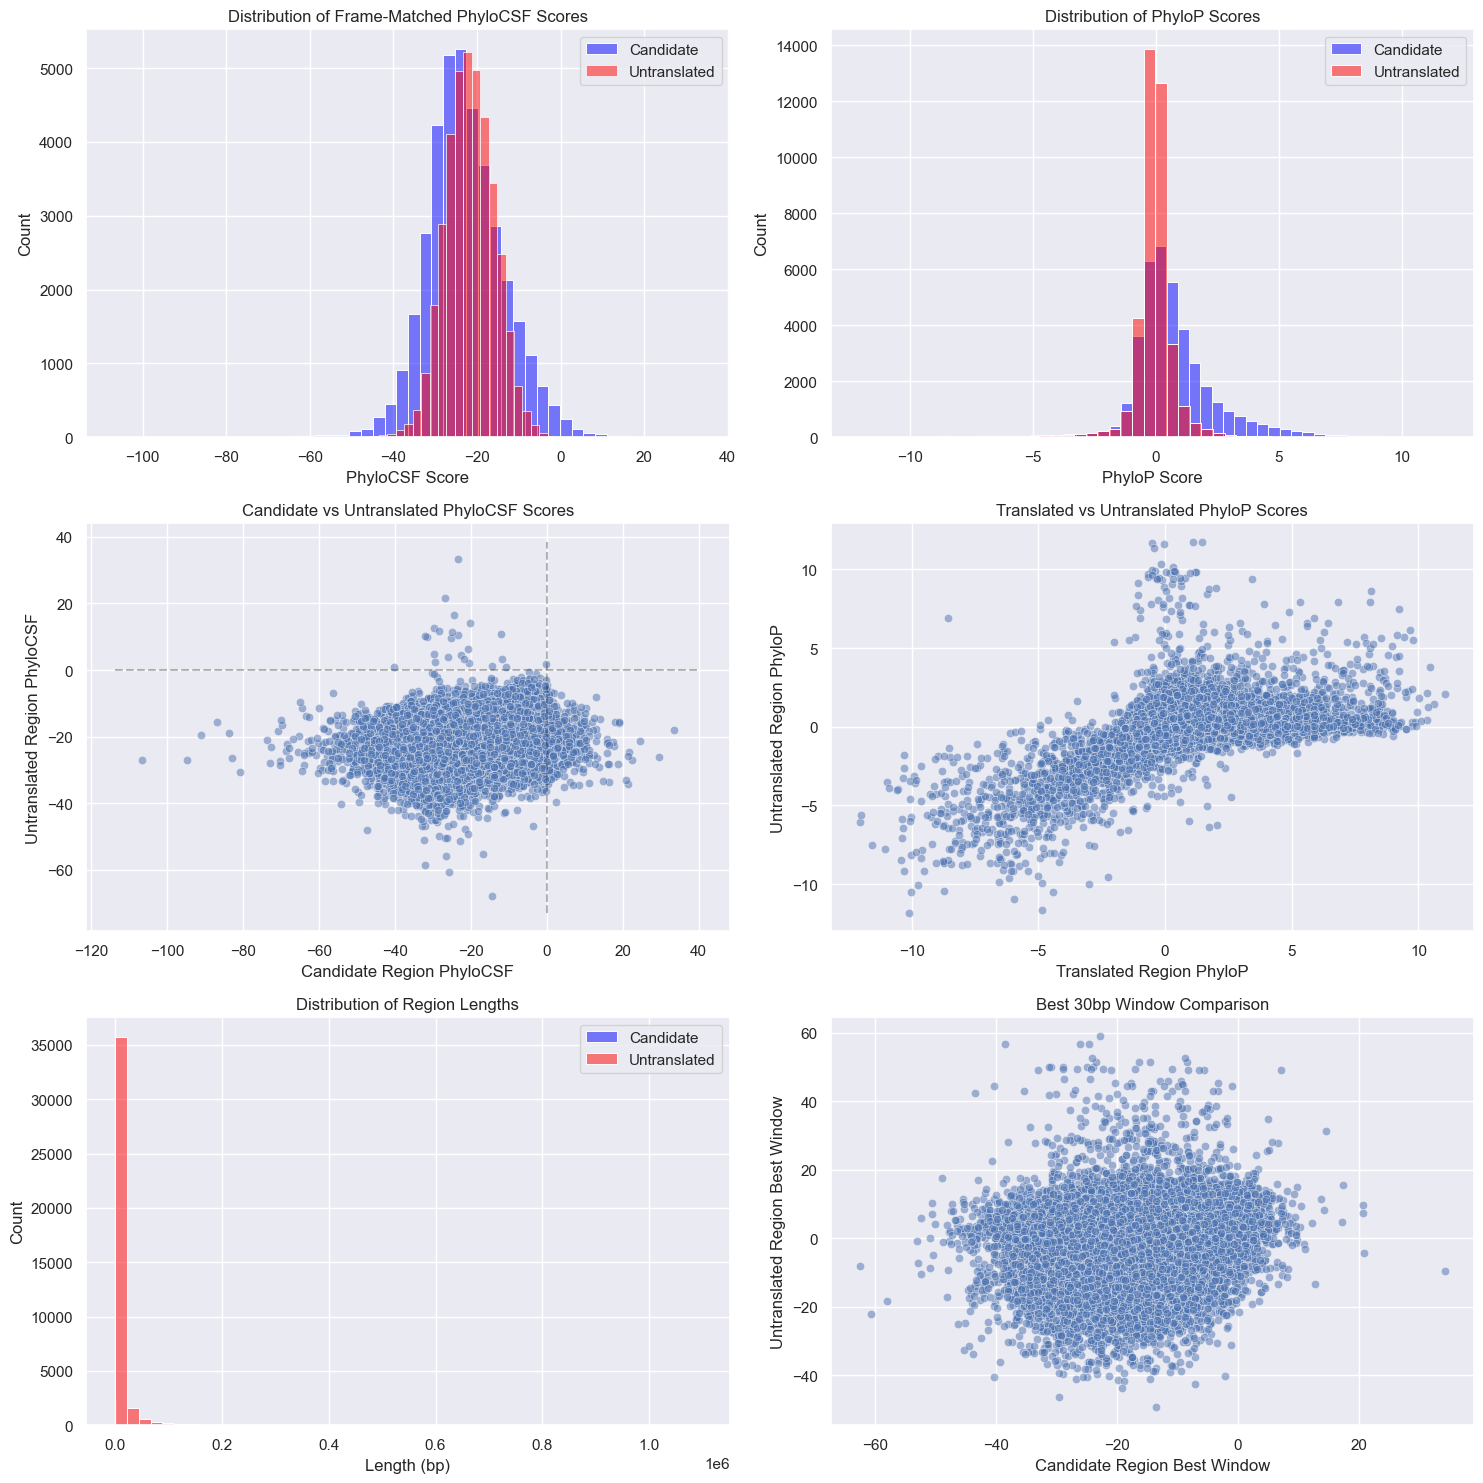


Writing phylocsf BED file...
../results/untranslated_intronic_extended/bed/intron_phylocsf_20241202.bed
Wrote 77517 entries to ../results/untranslated_intronic_extended/bed/intron_phylocsf_20241202.bed

First few lines of BED file:
shape: (5, 6)
┌──────────┬─────────┬─────────┬──────────────────────────────┬───────────┬────────┐
│ chr_name ┆ start   ┆ end     ┆ feature_name                 ┆ bed_score ┆ strand │
│ ---      ┆ ---     ┆ ---     ┆ ---                          ┆ ---       ┆ ---    │
│ str      ┆ i64     ┆ i64     ┆ str                          ┆ i64       ┆ str    │
╞══════════╪═════════╪═════════╪══════════════════════════════╪═══════════╪════════╡
│ chr1     ┆ 924950  ┆ 925103  ┆ ENST00000616016_1_translated ┆ 661       ┆ +      │
│ chr1     ┆ 1280667 ┆ 1280697 ┆ ENST00000379116_1_translated ┆ 0         ┆ +      │
│ chr1     ┆ 1435823 ┆ 1435865 ┆ ENST00000476993_1_translated ┆ 647       ┆ +      │
│ chr1     ┆ 1450758 ┆ 1450824 ┆ ENST00000378785_1_translated ┆ 659      

In [10]:
# Show distribution of scores for both regions
print("\nScore statistics for intron regions:")
print(scored_df.select([
   "transcript_id",
   "translated_coords",
   "intron_coords", 
   "strand",
   "translated_frame_score",
   "untranslated_frame_score",
   "translated_phylop",
   "untranslated_phylop",
   "frame"
]).head(10))

# Create visualization comparing translated and untranslated regions
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

# PhyloCSF scores distribution - translated vs untranslated
data = scored_df.to_pandas()

# Plot 1: PhyloCSF scores
sns.histplot(
    data=data['translated_frame_score'].dropna(),
    bins=50,
    ax=axes[0],
    color='blue',
    alpha=0.5,
    label='Candidate'
)
sns.histplot(
    data=data['untranslated_frame_score'].dropna(),
    bins=50,
    ax=axes[0],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[0].set_title("Distribution of Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")
axes[0].legend()

# Plot 2: PhyloP scores
sns.histplot(
    data=data['translated_phylop'].dropna(),
    bins=50,
    ax=axes[1],
    color='blue',
    alpha=0.5,
    label='Candidate'
)
sns.histplot(
    data=data['untranslated_phylop'].dropna(),
    bins=50,
    ax=axes[1],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[1].set_title("Distribution of PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")
axes[1].legend()

# Plot 3: PhyloCSF comparison
sns.scatterplot(
    data=data.dropna(subset=['translated_frame_score', 'untranslated_frame_score']),
    x='translated_frame_score',
    y='untranslated_frame_score',
    alpha=0.5,
    ax=axes[2]
)
axes[2].set_title("Candidate vs Untranslated PhyloCSF Scores")
axes[2].set_xlabel("Candidate Region PhyloCSF")
axes[2].set_ylabel("Untranslated Region PhyloCSF")
axes[2].plot([0, 0], axes[2].get_ylim(), 'k--', alpha=0.3)  # vertical line at x=0
axes[2].plot(axes[2].get_xlim(), [0, 0], 'k--', alpha=0.3)  # horizontal line at y=0

# Plot 4: PhyloP comparison
sns.scatterplot(
    data=data.dropna(subset=['translated_phylop', 'untranslated_phylop']),
    x='translated_phylop',
    y='untranslated_phylop',
    alpha=0.5,
    ax=axes[3]
)
axes[3].set_title("Translated vs Untranslated PhyloP Scores")
axes[3].set_xlabel("Translated Region PhyloP")
axes[3].set_ylabel("Untranslated Region PhyloP")

# Plot 5: Region lengths
sns.histplot(
    data=data['translated_length'].dropna(),
    bins=50,
    ax=axes[4],
    color='blue',
    alpha=0.5,
    label='Candidate'
)
sns.histplot(
    data=data['untranslated_length'].dropna(),
    bins=50,
    ax=axes[4],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[4].set_title("Distribution of Region Lengths")
axes[4].set_xlabel("Length (bp)")
axes[4].legend()

# Plot 6: Window max scores
sns.scatterplot(
    data=data.dropna(subset=['translated_window_max', 'untranslated_window_max']),
    x='translated_window_max',
    y='untranslated_window_max',
    alpha=0.5,
    ax=axes[5]
)
axes[5].set_title("Best 30bp Window Comparison")
axes[5].set_xlabel("Candidate Region Best Window")
axes[5].set_ylabel("Untranslated Region Best Window")

plt.tight_layout()
plt.show()

# Modified BED file writer for our specific columns
def write_scored_bed(df, translated_col, untranslated_col, output_path, scale_factor=1000):
    """Write BED file with both translated and untranslated regions"""
    
    # Create entries for translated regions
    translated_df = (df
        .with_columns([
            pl.format("chr{}", pl.col("chrom")).alias("chr_name"),
            pl.col("thickStart").alias("start"),
            pl.col("thickEnd").alias("end"),
            # Ensure unique names for browser display
            pl.format("{}_translated", pl.col("name")).alias("feature_name"),
            # Scale scores to BED format (0-1000)
            pl.when(pl.col(translated_col).is_null() | pl.col(translated_col).is_nan())
            .then(0)
            .otherwise(
                ((pl.col(translated_col) - pl.col(translated_col).filter(~pl.col(translated_col).is_nan()).min()) / 
                 (pl.col(translated_col).filter(~pl.col(translated_col).is_nan()).max() - 
                  pl.col(translated_col).filter(~pl.col(translated_col).is_nan()).min()) * scale_factor)
            )
            .floor()
            .cast(pl.Int64)
            .clip(0, 1000)
            .alias("bed_score")
        ])
        .select([
            "chr_name",
            "start",
            "end",
            "feature_name",
            "bed_score",
            "strand"
        ]))
    
    # Create entries for untranslated regions
    untranslated_df = (df
        .filter(pl.col("untranslated_length") > 0)  # Only include regions with untranslated sequence
        .with_columns([
            pl.format("chr{}", pl.col("chrom")).alias("chr_name"),
            pl.format("{}_untranslated", pl.col("name")).alias("feature_name"),
            # Scale scores for untranslated regions
            pl.when(pl.col(untranslated_col).is_null() | pl.col(untranslated_col).is_nan())
            .then(0)
            .otherwise(
                ((pl.col(untranslated_col) - pl.col(untranslated_col).filter(~pl.col(untranslated_col).is_nan()).min()) / 
                 (pl.col(untranslated_col).filter(~pl.col(untranslated_col).is_nan()).max() - 
                  pl.col(untranslated_col).filter(~pl.col(untranslated_col).is_nan()).min()) * scale_factor)
            )
            .floor()
            .cast(pl.Int64)
            .clip(0, 1000)
            .alias("bed_score")
        ]))
    
    # Get coordinates for untranslated regions
    untranslated_df = untranslated_df.with_columns([
        pl.col("intron_start").alias("start"),
        pl.col("intron_end").alias("end")
    ]).select([
        "chr_name",
        "start",
        "end",
        "feature_name",
        "bed_score",
        "strand"
    ])
    
    # Combine and write
    combined_df = pl.concat([translated_df, untranslated_df])
    
    combined_df.write_csv(
        output_path,
        separator="\t",
        include_header=False
    )
    
    print(f"Wrote {len(combined_df)} entries to {output_path}")
    print("\nFirst few lines of BED file:")
    print(combined_df.head())

# Generate BED files for different score types
date_str = datetime.now().strftime("%Y%m%d")
for score_type, (translated_col, untranslated_col) in {
    "phylocsf": ("translated_frame_score", "untranslated_frame_score"),
    "phylop": ("translated_phylop", "untranslated_phylop"),
    "window": ("translated_window_max", "untranslated_window_max")
}.items():
    output_path = RESULTS_DIR / "bed" / f"intron_{score_type}_{date_str}.bed"
    print(f"\nWriting {score_type} BED file...")
    print(output_path)
    write_scored_bed(scored_df, translated_col, untranslated_col, output_path)

# Print score statistics
print("\nScore column statistics:")
for col_pair in [
    ("translated_frame_score", "untranslated_frame_score"),
    ("translated_phylop", "untranslated_phylop"),
    ("translated_window_max", "untranslated_window_max")
]:
    for col in col_pair:
        if col in scored_df.columns:
            print(f"\n{col}:")
            print(f"Total values: {len(scored_df)}")
            print(f"Null values: {scored_df.filter(pl.col(col).is_null()).height}")
            print(f"NaN values: {scored_df.filter(pl.col(col).is_nan()).height}")
            print(f"Negative values: {scored_df.filter(pl.col(col) < 0).height}")
            print("Overall statistics:")
            print(scored_df.select(pl.col(col)).describe())

## Finding Novel Extension Regions

After calculating conservation scores for all potential N-terminal extensions, we need to identify which ones are truly novel (i.e., don't overlap with known coding sequences in other transcripts). This requires:

1. Prerequisites:
  - Bedtools installed (`conda install -c bioconda bedtools`)
  - Our scored BED files from the conservation analysis
  - GENCODE v47 CDS annotations in BED format

2. Steps to identify novel extensions:

```bash
# First convert GENCODE GTF CDS regions to BED
# If using UCSC genome browser coordinates (our case):
awk '$3=="CDS" {print $1"\t"$4-1"\t"$5}' data/raw/gencode.v47.annotation.gtf > gencode.v47.cds.bed


# Use bedtools ictersect to find non-overlapping regions - Examples
# For matched frame scores:
bedtools intersect -v -a cte_matched_frame_20241031.bed -b gencode.v47.cds.bed > novel_cte_matched_frame_20241031.bed

# For PhyloP scores:
bedtools intersect -v -a cte_phylop_20241031.bed -b gencode.v47.cds.bed > novel_cte_phylop_20241031.bed

# For window max scores:
bedtools intersect -v -a cte_window_max_20241031.bed -b gencode.v47.cds.bed > novel_cte_window_max_20241031.bed

## Results Output Organization

We should save both figures and data files for reproducibility and future reference. Here's what we should output:

### Figures
1. **Distribution Plots** (`results/cte/figures/`)
  - Score distributions:
    ```python
    # Distribution plots (4-panel)
    fig.savefig(RESULTS_DIR / "figures" / f"cte_score_distributions_{date_str}.pdf")
    fig.savefig(RESULTS_DIR / "figures" / f"cte_score_distributions_{date_str}.png", dpi=300)
    ```

2. **Correlation Plots**
  - PhyloCSF vs PhyloP
  - Score vs length relationships
  - Separate plots for clarity

### Tables/Data Files 
1. **Summary Statistics** (`results/cte/tables/`)


In [14]:
scored_df = scored_df.rename({col: col.replace('translated_', 'candidate_') for col in scored_df.columns if col.startswith('translated_')})

Wrote 77517 entries to ../results/untranslated_intronic_extended/bed/untranslated_intron_phylocsf_20241202.bed

First few lines of BED file:
shape: (5, 6)
┌──────────┬─────────┬─────────┬──────────────────────────────┬───────────┬────────┐
│ chr_name ┆ start   ┆ end     ┆ feature_name                 ┆ bed_score ┆ strand │
│ ---      ┆ ---     ┆ ---     ┆ ---                          ┆ ---       ┆ ---    │
│ str      ┆ i64     ┆ i64     ┆ str                          ┆ i64       ┆ str    │
╞══════════╪═════════╪═════════╪══════════════════════════════╪═══════════╪════════╡
│ chr1     ┆ 924950  ┆ 925103  ┆ ENST00000616016_1_translated ┆ 661       ┆ +      │
│ chr1     ┆ 1280667 ┆ 1280697 ┆ ENST00000379116_1_translated ┆ 0         ┆ +      │
│ chr1     ┆ 1435823 ┆ 1435865 ┆ ENST00000476993_1_translated ┆ 647       ┆ +      │
│ chr1     ┆ 1450758 ┆ 1450824 ┆ ENST00000378785_1_translated ┆ 659       ┆ +      │
│ chr1     ┆ 1915307 ┆ 1915430 ┆ ENST00000307786_1_translated ┆ 627       ┆ +   

<Figure size 1500x1000 with 0 Axes>

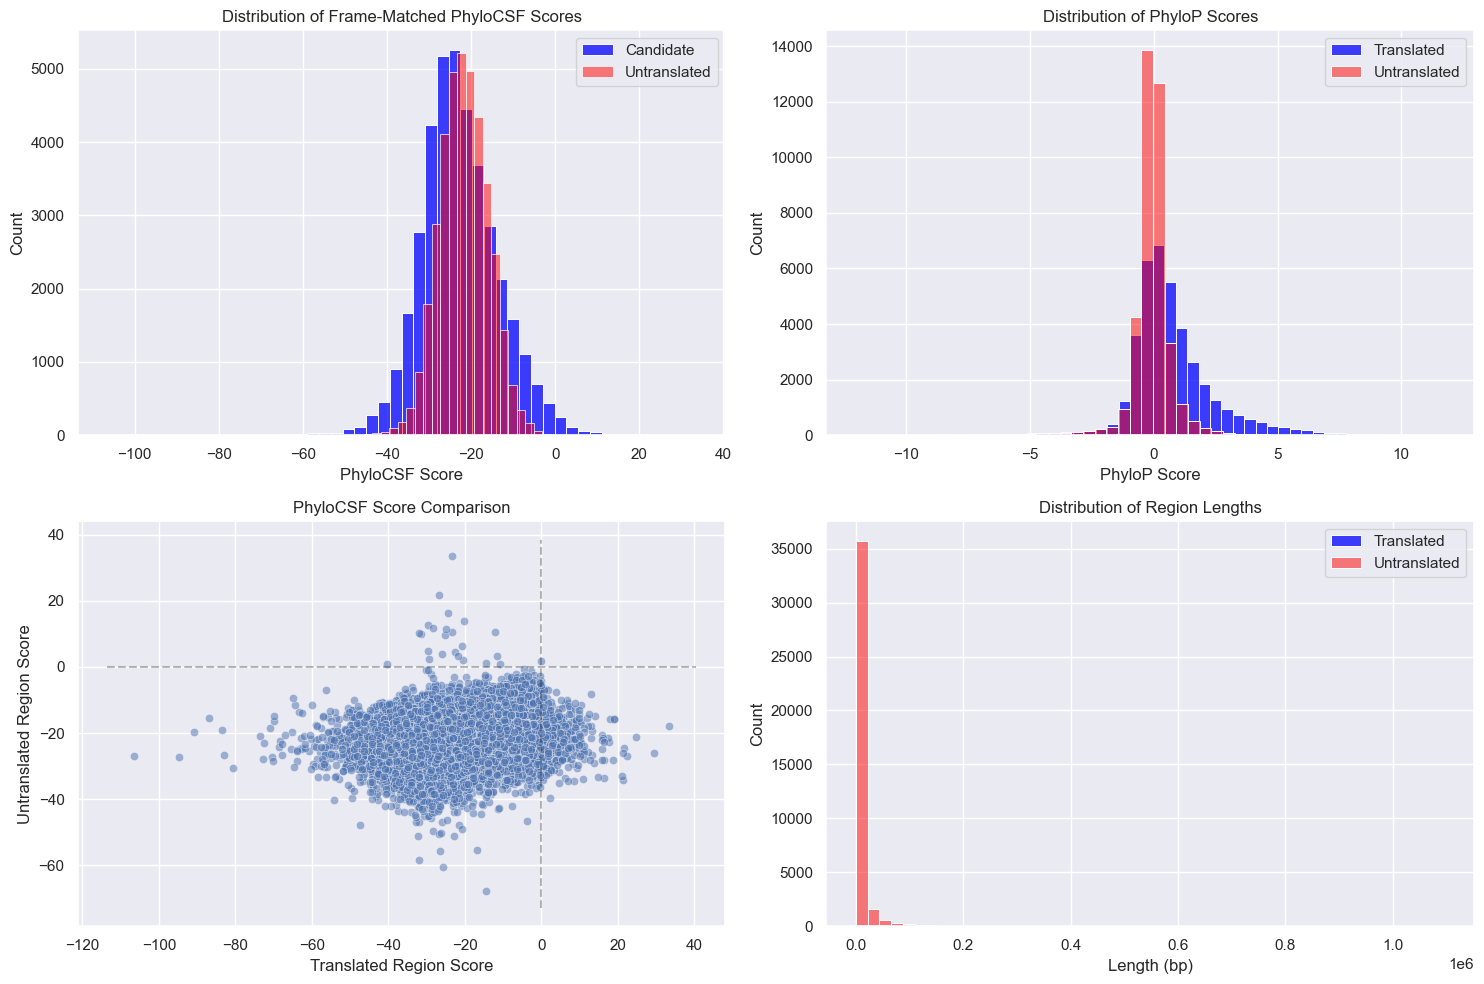

In [22]:
# Create directory structure
# RESULTS_DIR = Path("../results/retained_introns")
for subdir in ["figures", "tables", "bed"]:
    (RESULTS_DIR / subdir).mkdir(parents=True, exist_ok=True)

# Get current date for file naming
date_str = datetime.now().strftime("%Y%m%d")

# Save figures
plt.figure(figsize=(15, 10))
# Distribution plots (4-panel)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# PhyloCSF scores distribution
sns.histplot(
    data=scored_df.to_pandas(), 
    x="candidate_frame_score",
    bins=50,
    ax=axes[0],
    color='blue',
    label='Candidate'
)
sns.histplot(
    data=scored_df.to_pandas(), 
    x="untranslated_frame_score",
    bins=50,
    ax=axes[0],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[0].set_title("Distribution of Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")
axes[0].legend()

# PhyloP score distribution
sns.histplot(
    data=scored_df.to_pandas(), 
    x="candidate_phylop",
    bins=50,
    ax=axes[1],
    color='blue',
    label='Translated'
)
sns.histplot(
    data=scored_df.to_pandas(), 
    x="untranslated_phylop",
    bins=50,
    ax=axes[1],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[1].set_title("Distribution of PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")
axes[1].legend()

# PhyloCSF comparison
sns.scatterplot(
    data=scored_df.to_pandas(),
    x="candidate_frame_score",
    y="untranslated_frame_score",
    alpha=0.5,
    ax=axes[2]
)
axes[2].set_title("PhyloCSF Score Comparison")
axes[2].set_xlabel("Translated Region Score")
axes[2].set_ylabel("Untranslated Region Score")
axes[2].plot([0, 0], axes[2].get_ylim(), 'k--', alpha=0.3)
axes[2].plot(axes[2].get_xlim(), [0, 0], 'k--', alpha=0.3)

# Region lengths
sns.histplot(
    data=scored_df.to_pandas(),
    x="candidate_length",
    bins=50,
    ax=axes[3],
    color='blue',
    label='Translated'
)
sns.histplot(
    data=scored_df.to_pandas(),
    x="untranslated_length",
    bins=50,
    ax=axes[3],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[3].set_title("Distribution of Region Lengths")
axes[3].set_xlabel("Length (bp)")
axes[3].legend()

plt.tight_layout()

# Save the figure
fig.savefig(RESULTS_DIR / "figures" / f"untranslated_intron_score_distributions_{date_str}.pdf")
fig.savefig(RESULTS_DIR / "figures" / f"untranslated_intron_score_distributions_{date_str}.png", dpi=300)

# Save summary statistics
metrics = [
    "candidate_frame_score",
    "untranslated_frame_score",
    "candidate_phylop",
    "untranslated_phylop",
    "candidate_window_max",
    "untranslated_window_max",
    "candidate_length",
    "untranslated_length"
]

summary_stats = scored_df.select(metrics).describe()
summary_stats.write_csv(RESULTS_DIR / "tables" / f"untranslated_intron_summary_stats_{date_str}.tsv", separator="\t")

# Save full results
scored_df.write_csv(RESULTS_DIR / "tables" / f"untranslated_intron_full_results_{date_str}.tsv", separator="\t")

# Save high-confidence results
high_conf = scored_df.filter(
    (pl.col("candidate_frame_score") > 10) &
    (pl.col("candidate_phylop") > 2) &
    (pl.col("candidate_frame_score") > pl.col("untranslated_frame_score") * 2)
)
high_conf.write_csv(RESULTS_DIR / "tables" / f"untranslated_intron_high_confidence_{date_str}.tsv", separator="\t")

# Save BED files
for score_type, (translated_col, untranslated_col) in {
    "phylocsf": ("candidate_frame_score", "untranslated_frame_score"),
    "phylop": ("candidate_phylop", "untranslated_phylop"),
    "window": ("candidate_window_max", "untranslated_window_max")
}.items():
    output_path = RESULTS_DIR / "bed" / f"untranslated_intron_{score_type}_{date_str}.bed"
    write_scored_bed(scored_df, translated_col, untranslated_col, output_path)

print("Results saved in:")
print(f"- Figures: {RESULTS_DIR}/figures/")
print(f"- Tables: {RESULTS_DIR}/tables/")
print(f"- BED files: {RESULTS_DIR}/bed/")

In [ ]:
scored_df

chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,transcript_id,region_length,translated_frame_score,translated_max_score,translated_phylop,translated_window_max,untranslated_frame_score,untranslated_max_score,untranslated_phylop,untranslated_window_max,translated_length,untranslated_length,intron_start,intron_end,frame,translated_coords,intron_coords
str,i64,i64,str,i64,str,i64,i64,i64,i64,str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,str
"""1""",1013576,1013732,"""ENST00000649529_1""",156,"""+""",1013576,1013732,0,1,"""156""","""0""","""ENST00000649529""",156,-27.092769,-23.455135,-0.363019,-20.311,-27.295877,-27.295877,-0.328809,-8.4005,156,251,1013576,1013983,1,"""1:1013576-1013732""","""1:1013576-1013983"""
"""1""",22563731,22563824,"""ENST00000166244_1""",93,"""+""",22563731,22563824,0,1,"""93""","""0""","""ENST00000166244""",93,-7.554032,-5.568086,1.928796,2.7125,-25.098858,-24.472444,0.162624,1.9283,93,5466,22563729,22569288,3,"""1:22563731-22563824""","""1:22563729-22569288"""
"""1""",22711045,22711291,"""ENST00000374630_1""",246,"""+""",22711045,22711291,0,1,"""246""","""0""","""ENST00000374630""",246,-2.147462,-0.86045,4.368772,3.3908,-22.429281,-21.871133,0.120767,11.535,246,70131,22711043,22781420,3,"""1:22711045-22711291""","""1:22711043-22781420"""
"""1""",28553137,28553209,"""ENST00000373830_1""",72,"""+""",28553137,28553209,0,1,"""72""","""0""","""ENST00000373830""",72,-25.771916,-11.907653,0.975681,-20.9223,-23.635191,-23.635191,-0.2685,-5.0194,72,430,28553137,28553639,1,"""1:28553137-28553209""","""1:28553137-28553639"""
"""1""",28737147,28737423,"""ENST00000373812_1""",276,"""+""",28737147,28737423,0,1,"""276""","""0""","""ENST00000373812""",276,-9.948363,-8.350425,2.530649,6.763,-15.604744,-10.671906,1.060654,-1.1172,276,234,28737147,28737657,1,"""1:28737147-28737423""","""1:28737147-28737657"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""9""",39175804,39175948,"""ENST00000297668_1""",144,"""-""",39175804,39175948,0,1,"""144""","""0""","""ENST00000297668""",144,-16.373796,-13.900972,-1.656431,-10.941893,-13.305047,-13.305047,-0.252332,0.051,144,4174,39171630,39175948,2,"""9:39175804-39175948""","""9:39171630-39175948"""
"""9""",124356565,124356763,"""ENST00000259457_1""",198,"""-""",124356565,124356763,0,1,"""198""","""0""","""ENST00000259457""",198,-27.410712,-26.593141,0.186884,-19.3139,-23.490516,-23.490516,-0.345711,-7.2994,198,2856,124353709,124356763,1,"""9:124356565-124356763""","""9:124353709-124356763"""
"""9""",136219007,136219028,"""ENST00000358701_1""",21,"""-""",136219007,136219028,0,1,"""21""","""0""","""ENST00000358701""",21,-17.647048,-17.647048,0.193524,null,-25.50295,-22.568168,-1.58159,-12.8363,21,200,136218808,136219029,2,"""9:136219007-136219028""","""9:136218808-136219029"""
